In [132]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, argrelextrema
from peak_detection import detect_spikes

Constants

In [130]:
POINTS_PER_SECOND = 25000
DT = 1 / POINTS_PER_SECOND
FILE_PATH = "/Volumes/WD Passport/DataScienceProject/220113_S1_m.h5"
PRIMARY_COLOUR = "black"

In [118]:
def print_structure(name, obj):
    print(name)

with h5py.File(FILE_PATH, "r") as f:

    # view the hdf5 file structure
    f.visititems(print_structure)

    # get the channel data
    channel_data = f['Data/Recording_0/AnalogStream/Stream_0/ChannelData']

    print(f"\nChannel Data is type: {type(channel_data)} of size: {channel_data.size} and shape: {channel_data.shape}")
    
    # access the first second of data points from each channel
    first_second_of_data = channel_data[:, :POINTS_PER_SECOND]

    two_thousandth_second_of_data = channel_data[:, 2000 * POINTS_PER_SECOND:2001* POINTS_PER_SECOND]
    five_thousandth_second_of_data = channel_data[:, 4500 * POINTS_PER_SECOND:4501* POINTS_PER_SECOND]
    
    print(f"\n{len(first_second_of_data)} channels with {len(first_second_of_data[0])} values in each")

Data
Data/Recording_0
Data/Recording_0/AnalogStream
Data/Recording_0/AnalogStream/Stream_0
Data/Recording_0/AnalogStream/Stream_0/ChannelData
Data/Recording_0/AnalogStream/Stream_0/ChannelDataTimeStamps
Data/Recording_0/AnalogStream/Stream_0/InfoChannel

Channel Data is type: <class 'h5py._hl.dataset.Dataset'> of size: 7307400000 and shape: (60, 121790000)

60 channels with 25000 values in each


Let's access the first second of data and show how some of the channels simultaneously

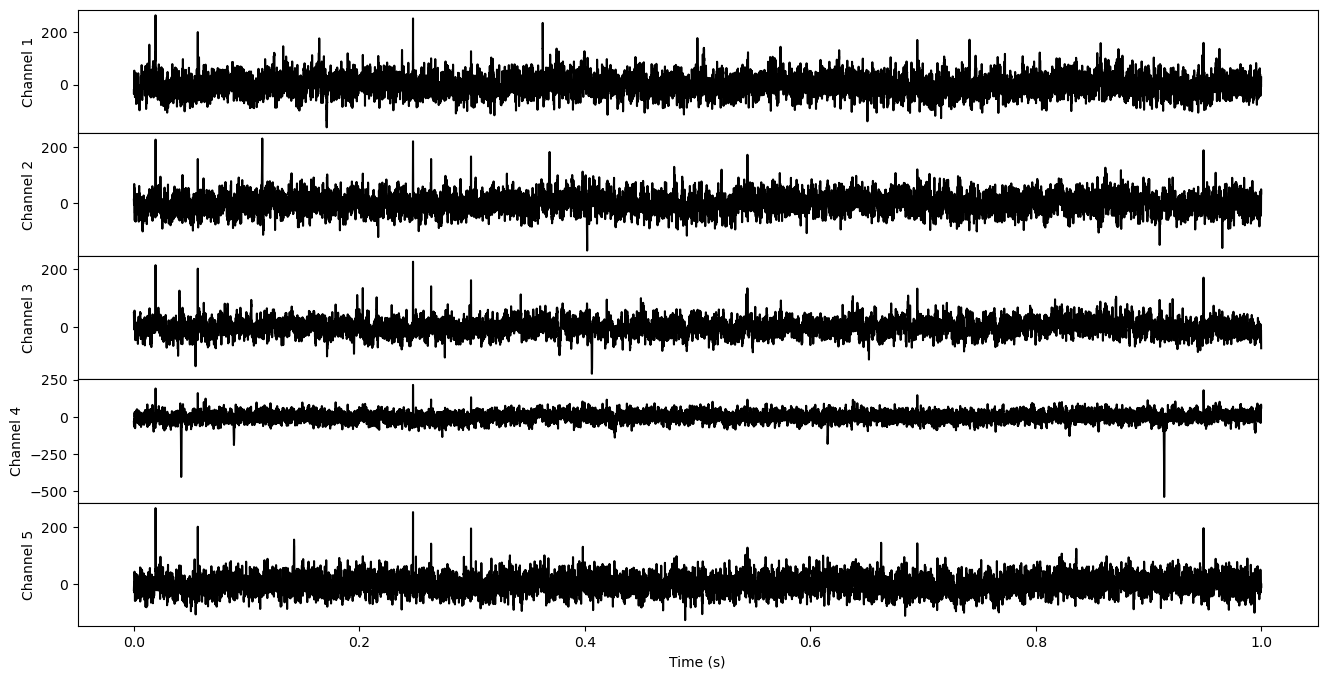

In [119]:
# so the time difference between each data point is 1/25000 seconds
time = np.arange(len(first_second_of_data[0])) / POINTS_PER_SECOND
five_channel_data = first_second_of_data[:5]

fig, axs = plt.subplots(5, 1, figsize=(16, 8), sharex=True)

for i in range(5):  
    data_points = five_channel_data[i, :] 
    axs[i].plot(time, data_points, c=PRIMARY_COLOUR)
    axs[i].set_ylabel(f'Channel {i+1}') 

axs[-1].set_xlabel('Time (s)') 

plt.subplots_adjust(hspace=0) 
plt.show()

In [120]:
# define the frequency band
lowcut = 300.0
highcut = 3000.0

# define the Butterworth filter
nyquist = 0.5 * POINTS_PER_SECOND
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(1, [low, high], btype='band')

# apply the filter to the data
filtered_data = filtfilt(b, a, two_thousandth_second_of_data)

Compare the first channels signal before and after filtering

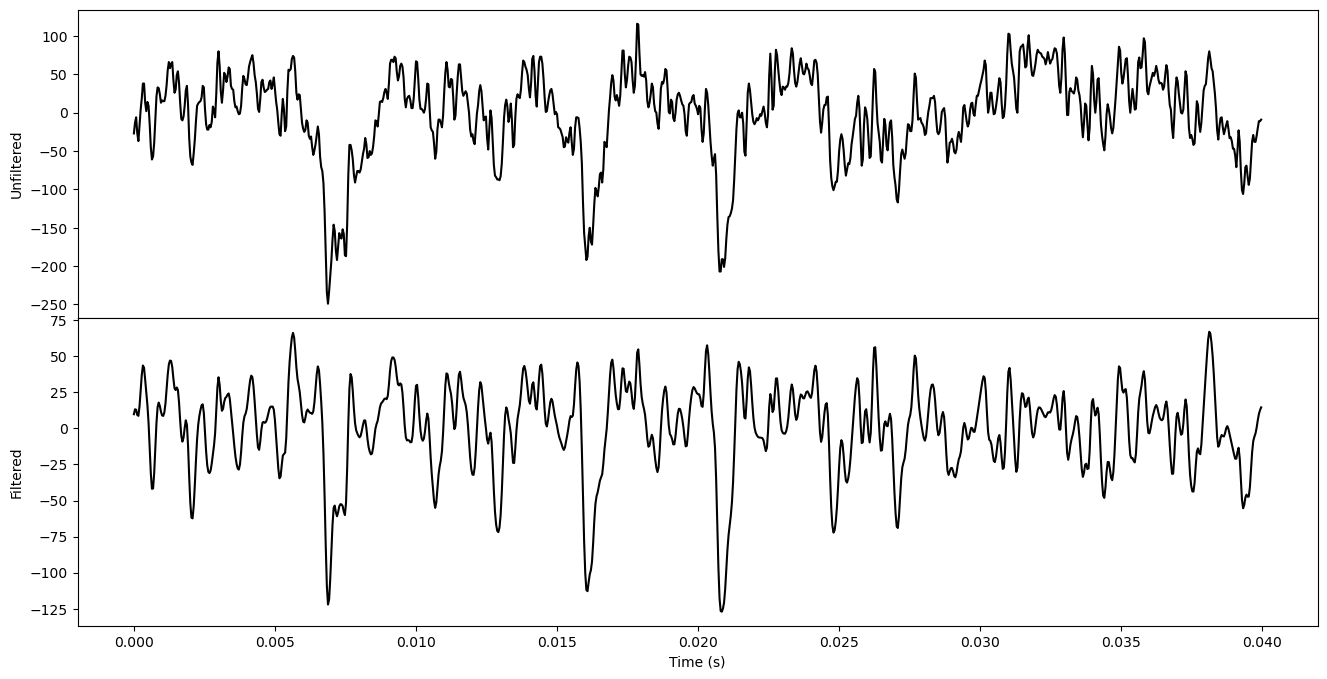

In [121]:
channel = 49

# so the time difference between each data point is 1/25000 seconds
time = np.arange(len(filtered_data[channel])) / POINTS_PER_SECOND

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

axs[0].plot(time[:1000], two_thousandth_second_of_data[channel][:1000], c=PRIMARY_COLOUR)
axs[0].set_ylabel(f'Unfiltered') 
axs[1].plot(time[:1000], filtered_data[channel][:1000], c=PRIMARY_COLOUR)
axs[1].set_ylabel(f'Filtered') 

axs[-1].set_xlabel('Time (s)') 

plt.subplots_adjust(hspace=0) 
plt.show()

In [146]:
# calculate the threshold for each channel
threshold_multiplier = -4

mad = np.median(np.abs(filtered_data - np.median(filtered_data, axis=1, keepdims=True)) / 0.6745, axis=1)
thresholds = threshold_multiplier * mad

Text(0, 0.5, 'Voltage')

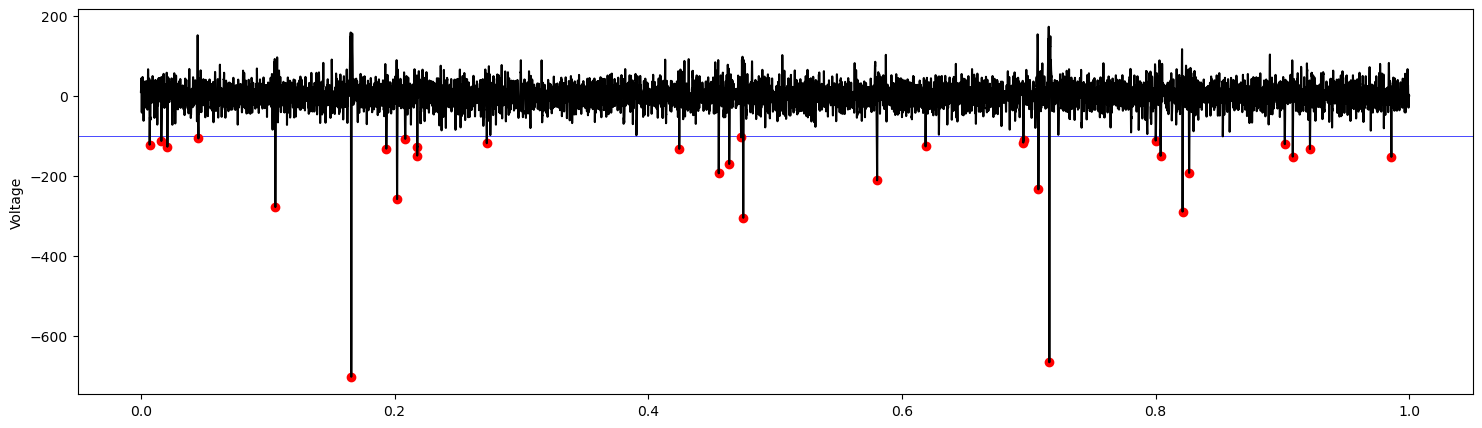

In [147]:
# channel to visualise
channel = 49

# get this channel's threshold value
threshold = thresholds[channel]

spikes = detect_spikes(filtered_data[channel], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, Flipped=True)

plt.figure(figsize=(18, 5))

plt.plot(time, filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR)
plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
plt.scatter(spikes * DT, filtered_data[channel][spikes], color='red')

# plt.xlim((0.025,0.075))
plt.ylabel('Voltage')

The spikes are added to a list where each is represented by a dictionary in this form:
    {
        'spike_start': 138, 
        'lowest_value': -122.1, 
        'highest_value': 66.2, 
        'duration': 69, 
        'values': array([  45.99129124, 63.04728503, ..., -5.18727283]) 
    }

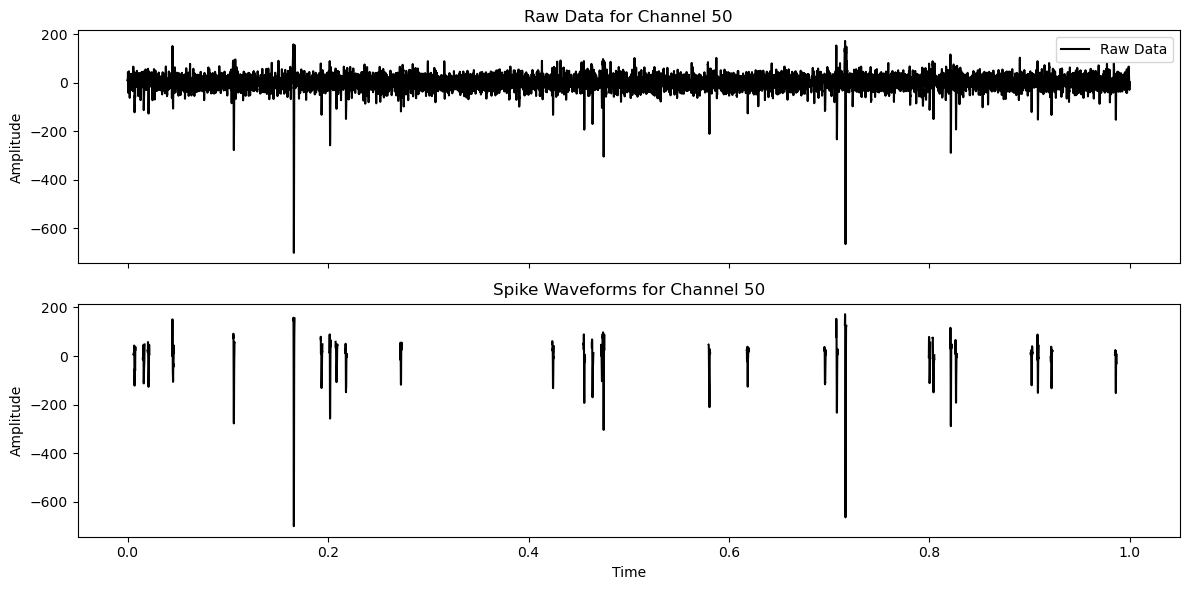

In [126]:
# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot the raw data
axs[0].plot(time, filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR)
axs[0].set_ylabel('Amplitude')
axs[0].set_title(f'Raw Data for Channel {channel+1}')
axs[0].legend()

spikes = []
# Plot the spike waveforms
for start, end in zip(spike_starts, spike_ends):
    # Extract the window around the spike
    spike_window = slice(max(0, start - window), min(len(time), end + window))

    spike_info = {
        'spike_start': start - window,
        'lowest_value': np.min(filtered_data[channel, spike_window]),
        'highest_value': np.max(filtered_data[channel, spike_window]),
        'duration': (end + window) - (start - window),
        'values': filtered_data[channel, spike_window]
    }
    
    # Add the dictionary to the list
    spikes.append(spike_info)
    
    # Plot the spike waveform
    axs[1].plot(time[spike_window], filtered_data[channel, spike_window], c=PRIMARY_COLOUR)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].set_title(f'Spike Waveforms for Channel {channel+1}')

plt.tight_layout()
plt.show()

Let's plot an example spike waveform

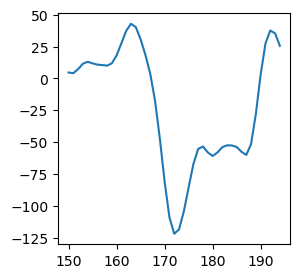

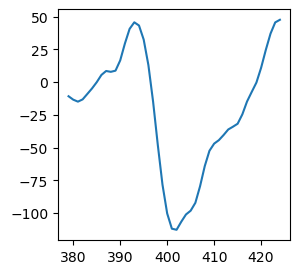

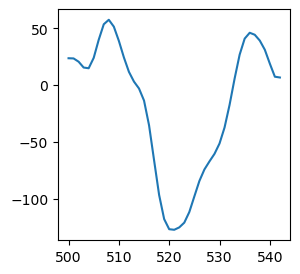

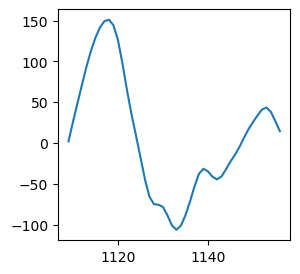

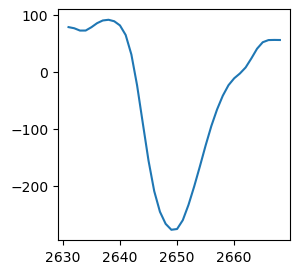

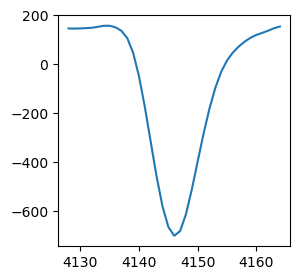

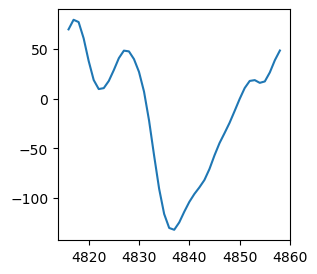

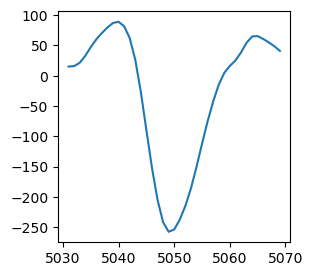

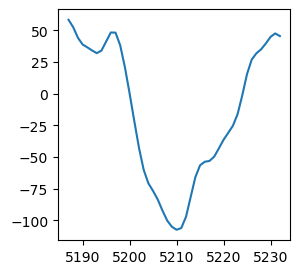

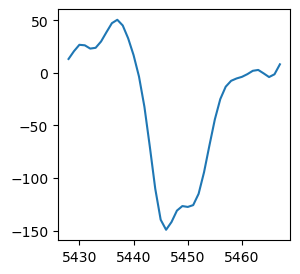

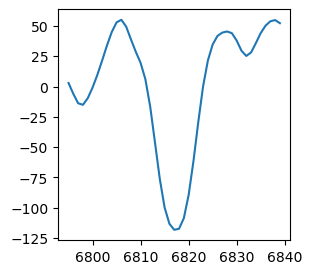

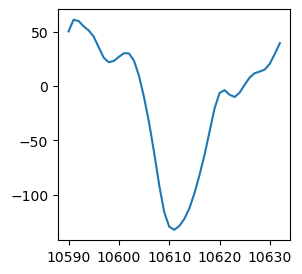

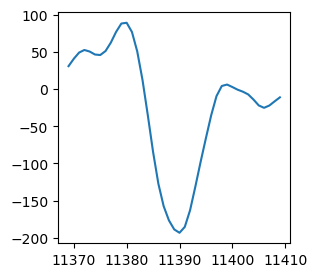

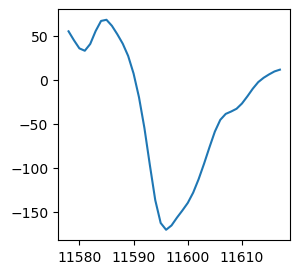

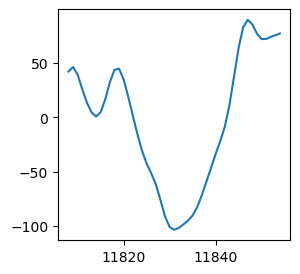

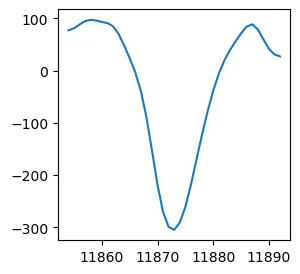

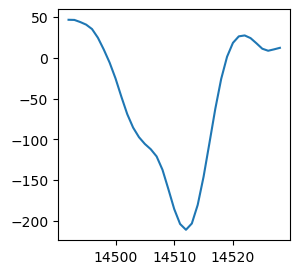

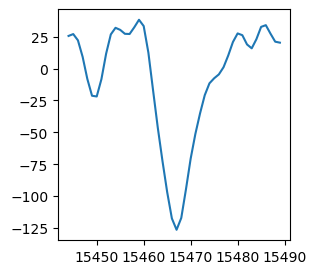

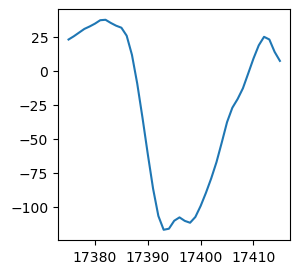

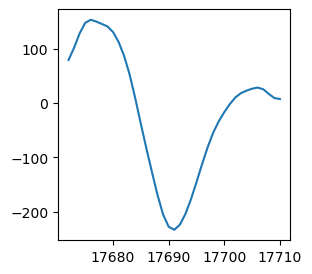

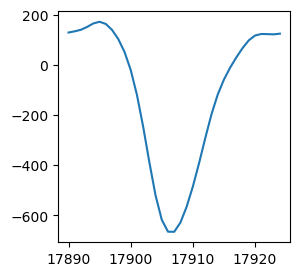

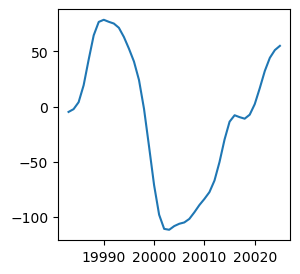

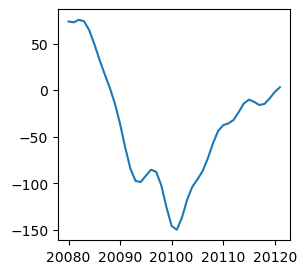

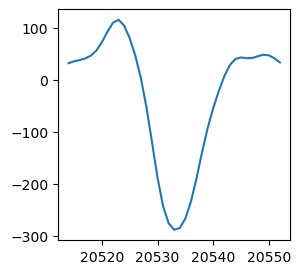

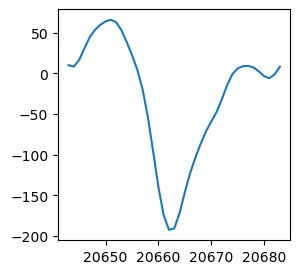

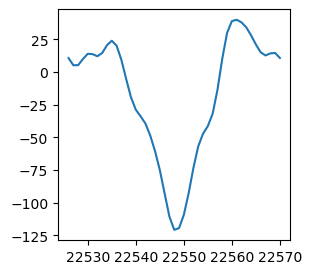

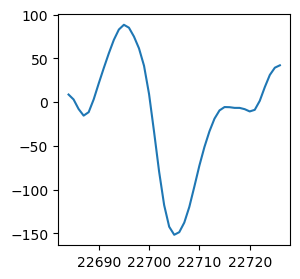

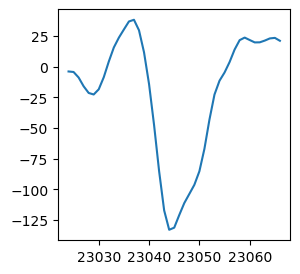

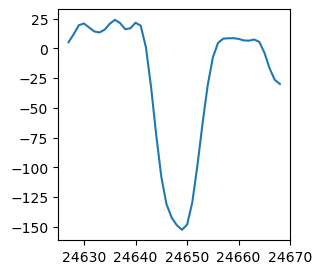

In [125]:
for i in range(len(spikes)):

    example_spike = spikes[i]

    x = np.arange(example_spike["spike_start"], example_spike["spike_start"] + example_spike["duration"])

    plt.figure(figsize=(3, 3))

    plt.plot(x, example_spike["values"])
    plt.show()